<a href="https://colab.research.google.com/github/elisa-desmetz/Deep_Learning-Fire_Detection/blob/master/Fire_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fire Detection - Computer vision

Model detecting fire in images.

Data from [Kaggle](https://www.kaggle.com/phylake1337/fire-dataset)

In [106]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import os.path
from pathlib import Path
import glob

from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.applications.vgg16 import preprocess_input, decode_predictions

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN, LSTM, GlobalAveragePooling2D, SeparableConv2D
from keras import models
from keras import layers
import tensorflow as tf
from keras import backend as K
from keras.optimizers import Optimizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [46]:
path_drive = Path('../content/drive/MyDrive/fire_dataset')
path_repo = Path('./fire_dataset')

PNG_drive = list(path_drive.glob(r"*/*.png"))
PNG_repo = list(path_repo.glob(r"*/*.png"))

In [47]:
PNG_drive_label = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],PNG_drive))
print("FIRE: ", PNG_drive_label.count("fire_images"))
print("NO_FIRE: ", PNG_drive_label.count("non_fire_images"))

FIRE:  755
NO_FIRE:  244


In [53]:
PNG_Path_Series = pd.Series(PNG_drive,name="PNG").astype(str)
PNG_Labels_Series = pd.Series(PNG_drive_label,name="CATEGORY")
PNG_Labels_Series.replace({"non_fire_images":"NO_FIRE","fire_images":"FIRE"},inplace=True)

In [54]:
train_data = pd.concat([PNG_Path_Series,PNG_Labels_Series],axis=1)
# shuffling data
train_data = train_data.sample(frac=1).reset_index(drop=True)
print(train_data.head(-1))

                                                   PNG CATEGORY
0    ../content/drive/MyDrive/fire_dataset/non_fire...  NO_FIRE
1    ../content/drive/MyDrive/fire_dataset/fire_ima...     FIRE
2    ../content/drive/MyDrive/fire_dataset/non_fire...  NO_FIRE
3    ../content/drive/MyDrive/fire_dataset/non_fire...  NO_FIRE
4    ../content/drive/MyDrive/fire_dataset/fire_ima...     FIRE
..                                                 ...      ...
993  ../content/drive/MyDrive/fire_dataset/fire_ima...     FIRE
994  ../content/drive/MyDrive/fire_dataset/non_fire...  NO_FIRE
995  ../content/drive/MyDrive/fire_dataset/fire_ima...     FIRE
996  ../content/drive/MyDrive/fire_dataset/fire_ima...     FIRE
997  ../content/drive/MyDrive/fire_dataset/fire_ima...     FIRE

[998 rows x 2 columns]


#Data exploration

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


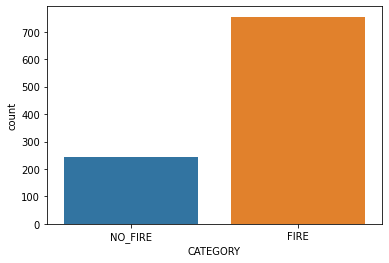

In [55]:
sns.countplot(train_data["CATEGORY"])
plt.show()

Text(0.5, 1.0, 'NO_FIRE')

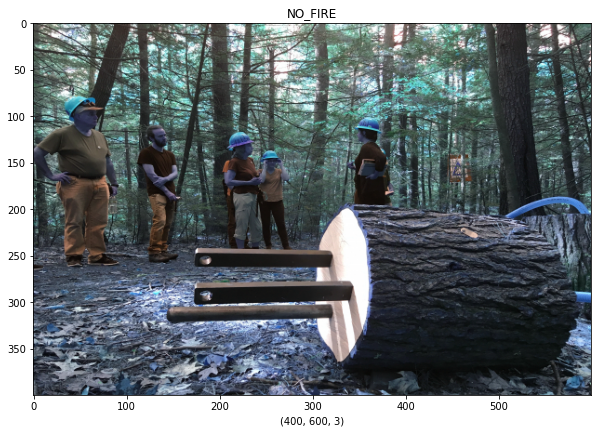

In [59]:
figure = plt.figure(figsize=(10,10))
x = cv2.imread(str(train_data["PNG"][0]))
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(train_data["CATEGORY"][0])

Text(0.5, 1.0, 'FIRE')

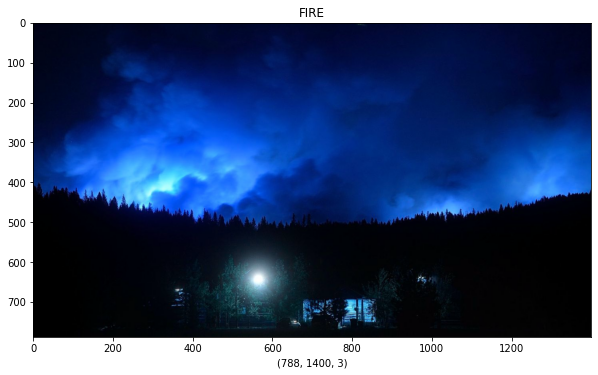

In [60]:
figure = plt.figure(figsize=(10,10))
x = cv2.imread(train_data["PNG"][997])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(train_data["CATEGORY"][997])

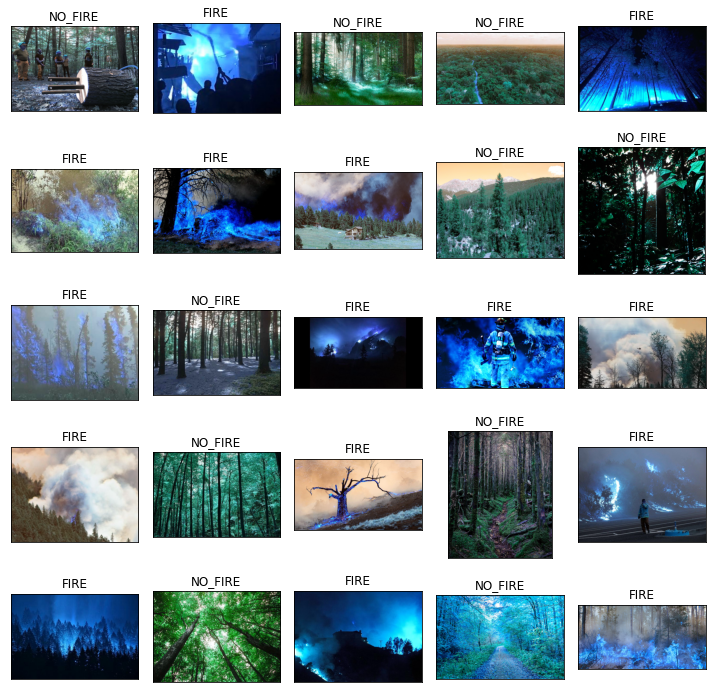

In [64]:
fig, axes = plt.subplots(nrows=5,
                        ncols=5,
                        figsize=(10,10),
                        subplot_kw={"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(cv2.imread(train_data["PNG"][i]))
    ax.set_title(train_data["CATEGORY"][i])
plt.tight_layout()
plt.show()

#Train and test datasets
Train dataset with data augmentation

In [66]:
Train_Generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.1)
Test_Generator = ImageDataGenerator(rescale=1./255)

## Splitting train and test datasets

In [73]:
Train_Data,Test_Data = train_test_split(train_data,train_size=0.9,random_state=42,shuffle=True)
encode = LabelEncoder()
For_Prediction_Class = encode.fit_transform(Test_Data["CATEGORY"])

### How data augmentation looks like

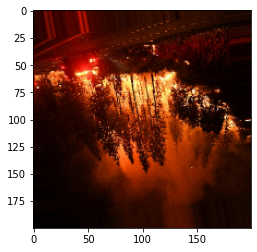

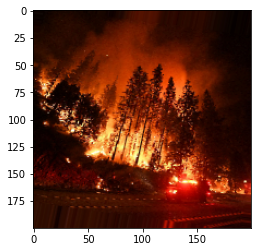

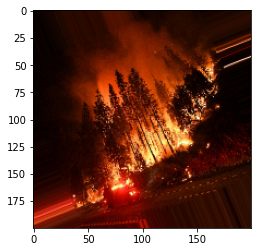

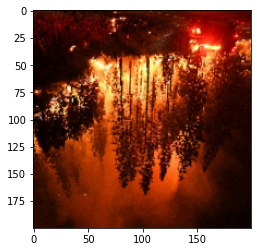

In [76]:
example_Image = Train_Data["PNG"][42]
Load_Image = image.load_img(example_Image,target_size=(200,200))
Array_Image = image.img_to_array(Load_Image)
Array_Image = Array_Image.reshape((1,) + Array_Image.shape)

i = 0
for batch in Train_Generator.flow(Array_Image,batch_size=1):
    plt.figure(i)
    IMG = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [77]:
Train_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=Train_Data,
                                                   x_col="PNG",
                                                   y_col="CATEGORY",
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   batch_size=32,
                                                   subset="training")

Found 810 validated image filenames belonging to 2 classes.


In [78]:
Validation_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=Train_Data,
                                                   x_col="PNG",
                                                   y_col="CATEGORY",
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   batch_size=32,
                                                   subset="validation")

Found 89 validated image filenames belonging to 2 classes.


In [79]:
Test_IMG_Set = Test_Generator.flow_from_dataframe(dataframe=Test_Data,
                                                 x_col="PNG",
                                                 y_col="CATEGORY",
                                                 color_mode="rgb",
                                                 class_mode="categorical",
                                                 batch_size=32)

Found 100 validated image filenames belonging to 2 classes.


# CNN

In [115]:
Model = tf.keras.models.Sequential([
  # inputs 
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Flatten(input_shape=(256,)),
  # hiddens layers
  tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  # output layer
  tf.keras.layers.Dense(2,activation="softmax")
])

In [116]:
Model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
fit_model = Model.fit(Train_IMG_Set,
                          validation_data=Validation_IMG_Set,
                          callbacks=Call_Back,
                      epochs=30)

Epoch 1/30
26/26 [==============================] - 39s 1s/step - loss: 0.4974 - accuracy: 0.7481 - val_loss: 0.4481 - val_accuracy: 0.7978
Epoch 2/30
26/26 [==============================] - 37s 1s/step - loss: 0.3632 - accuracy: 0.8247 - val_loss: 0.4044 - val_accuracy: 0.7865
Epoch 3/30
26/26 [==============================] - 38s 1s/step - loss: 0.3494 - accuracy: 0.8259 - val_loss: 0.2990 - val_accuracy: 0.8539
Epoch 4/30
26/26 [==============================] - 38s 1s/step - loss: 0.2693 - accuracy: 0.8938 - val_loss: 0.2744 - val_accuracy: 0.8989
Epoch 5/30
26/26 [==============================] - 38s 1s/step - loss: 0.2553 - accuracy: 0.9086 - val_loss: 0.2588 - val_accuracy: 0.8652
Epoch 6/30
26/26 [==============================] - 38s 1s/step - loss: 0.2099 - accuracy: 0.9247 - val_loss: 0.2416 - val_accuracy: 0.9101
Epoch 7/30
26/26 [==============================] - 38s 1s/step - loss: 0.2120 - accuracy: 0.9222 - val_loss: 0.3614 - val_accuracy: 0.8652
Epoch 8/30
26/26 [==

In [117]:
print(Model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, None, None, None)  0         
                                                                 
 flatten_3 (Flatten)         (None, None)              0         
                                                                 
 dense_7 (Dense)             (None, 128)               25165952  
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 2)                 130       
                                                                 
Total params: 25,174,338
Trainable params: 25,174,338


In [118]:
Model_Results = Model.evaluate(Test_IMG_Set)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.2f" % Model_Results[1])

4/4 [==============================] - 3s 761ms/step - loss: 0.0905 - accuracy: 0.9600
LOSS:  0.0905
ACCURACY:  0.96


No handles with labels found to put in legend.


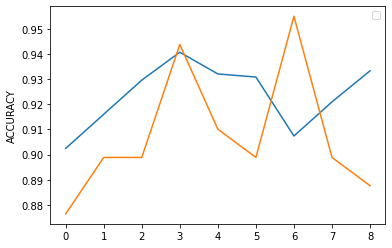

In [112]:
plt.plot(fit_model.history["accuracy"])
plt.plot(fit_model.history["val_accuracy"])
plt.ylabel("ACCURACY")
plt.legend()
plt.show()

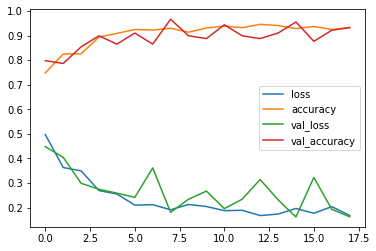

In [120]:
Dict_Summary = pd.DataFrame(fit_model.history)
Dict_Summary.plot()

#Prediction

In [121]:
Prediction = Model.predict(Test_IMG_Set)
Prediction = Prediction.argmax(axis=-1)

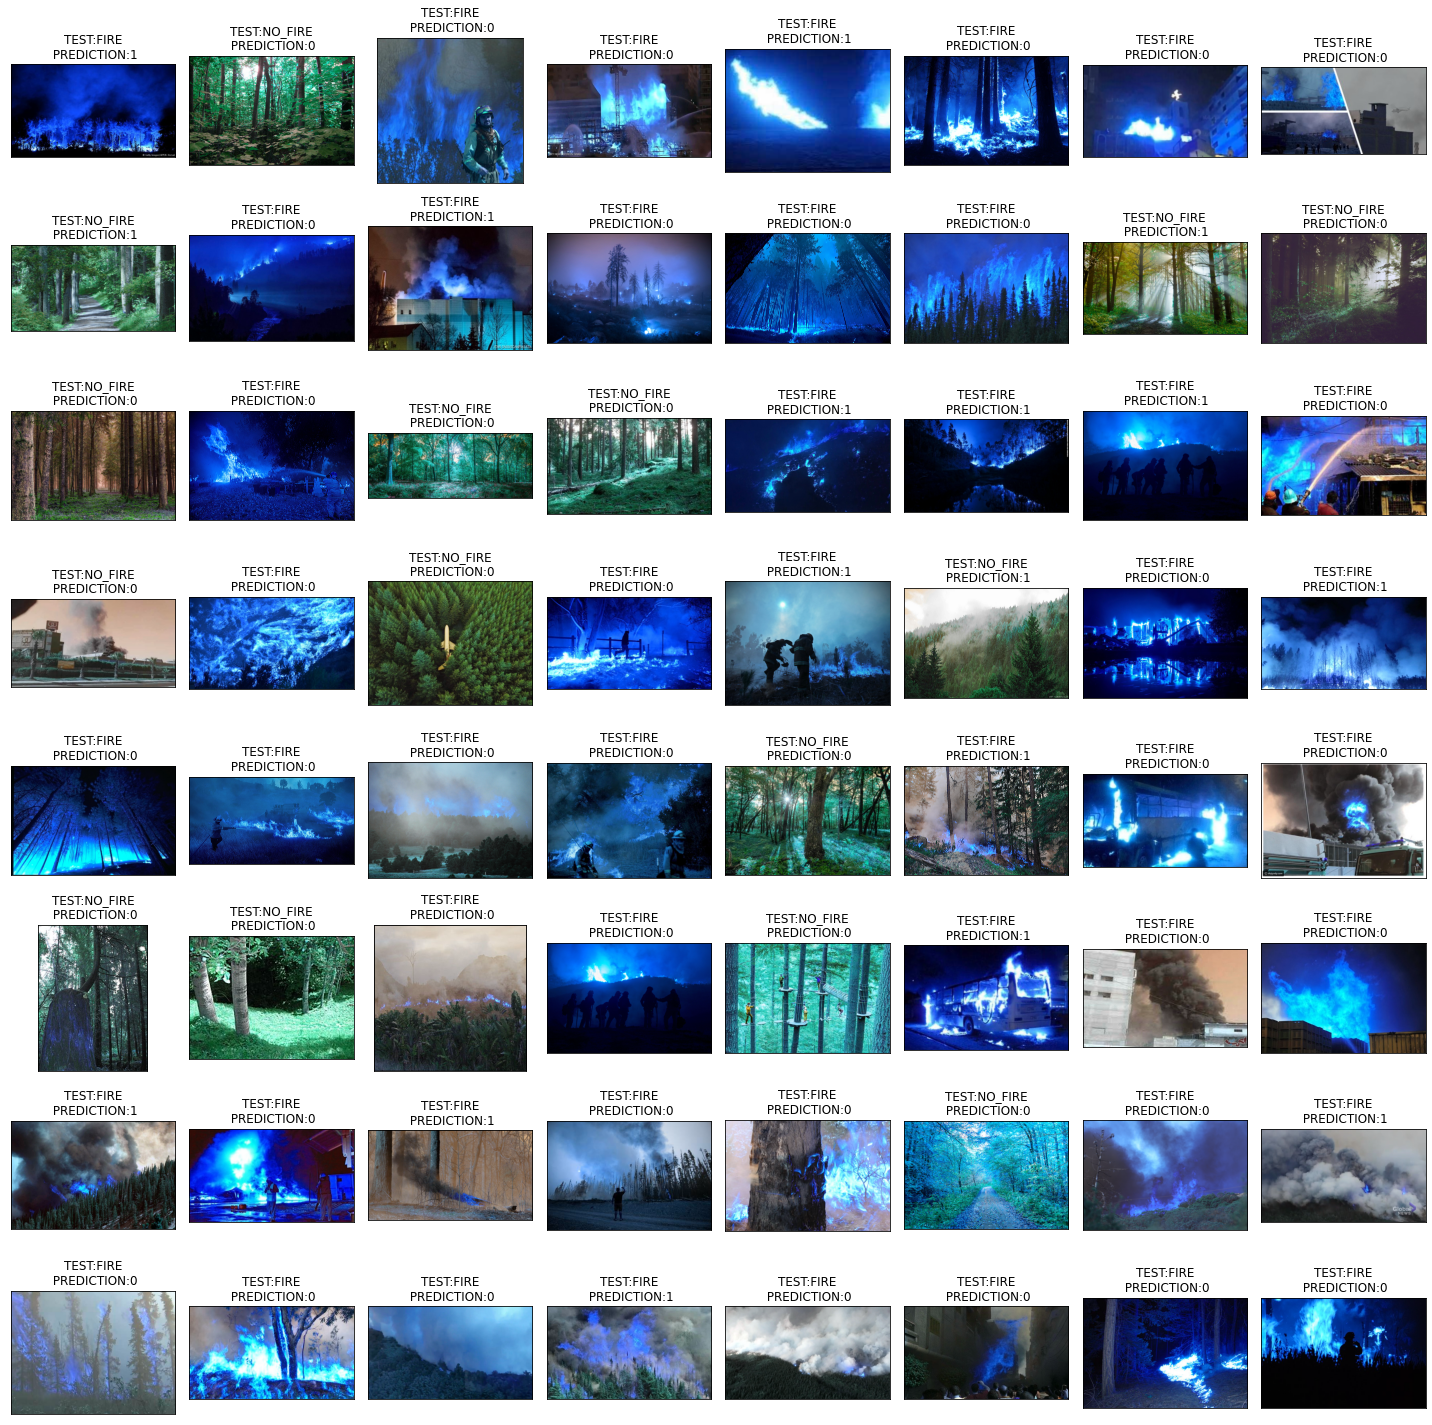

In [122]:
fig, axes = plt.subplots(nrows=8,
                         ncols=8,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.imread(Test_Data["PNG"].iloc[i]))
    ax.set_title(f"TEST:{Test_Data.CATEGORY.iloc[i]}\n PREDICTION:{Prediction[i]}")
plt.tight_layout()
plt.show()

In [130]:
Prediction_Class= np.argmax(Model.predict(Test_IMG_Set), axis=-1)

In [135]:
print(confusion_matrix(For_Prediction_Class,Prediction_Class))

[[54 16]
 [18 12]]


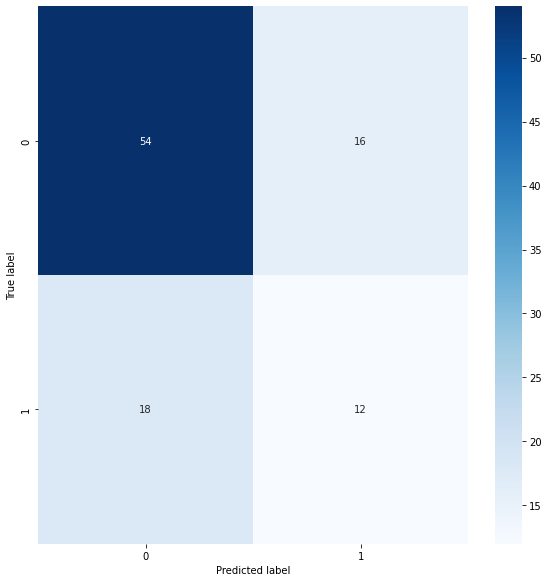

In [146]:
con_mat = tf.math.confusion_matrix(labels=For_Prediction_Class, predictions=Prediction_Class).numpy()

con_mat_df = pd.DataFrame(con_mat)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [150]:
Model.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets
